In [1]:
# import torch.multiprocessing as mp
# mp.set_start_method('spawn', force=True)
import torch; print("torch", torch.__version__)
from torch.utils.data import DataLoader
from torch import nn
# from torch.utils.tensorboard import SummaryWriter

import torchvision; print("torchvision", torchvision.__version__)
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import requests
from timeit import default_timer as timer
import random
import os
import subprocess
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
from typing import Tuple, List, Dict

import sklearn; print("sklear", sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

try:
    from torchinfo import summary
except:
    %pip -q install torchinfo
    from torchinfo import summary

try:
    from facenet_pytorch.models.mtcnn import MTCNN
except:
    %pip install facenet-pytorch
    from facenet_pytorch.models.mtcnn import MTCNN
import cv2

from helper_functions import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

set_seeds(42)

torch 2.3.1
torchvision 0.18.1
sklear 1.5.0
device: cuda


## 1. Getting Data

In [3]:
# os.mkdir("./utkface_new")

# ! kaggle datasets download -d jangedoo/utkface-new

# !unzip -o -j -q utk_faces.zip -d ./utk_faces

# print(len(glob("./utkface_new/***")))

## 2. Create DataFrame, Datasets and DataLoaders

#### 2.0 Preprocessing Data

In [13]:
data_dir3 = Path("./croped_images")

len(list(data_dir3.glob('*.jpg')))

11781

#### 2.1 DataFrame

In [15]:
data_dict = {"Img_id" : [],
             "Age" : [],
             "Gender" : [],
             "Year" : [],
             "path" : []
             }

data_dir1 = Path("./utkface_new")
files1 = list(data_dir1.glob('*.jpg'))


for i, item in enumerate(tqdm(files1, total=len(files1))):

    data_dict["Img_id"].append(item.stem)

    try:
        data_dict["Age"].append(int(item.stem.split("_")[0]))
    except Exception as e:
        print("Age:", i, item)

    try:
        data_dict["Gender"].append(int(item.stem.split("_")[1]))
    except Exception as e:
        print("Gender:", i, item)

    try:
        data_dict["Year"].append(int(item.stem.split("_")[-1][:4]))
    except Exception as e:
        print("Year:", i, item)

    data_dict["path"].append("./" / Path(item))
    
    img = Image.open("./" / Path(item))
    ch = len(img.getbands())
    if  ch != 3:
        print(i, item, ch)
        img.convert('RGB').save("./" / Path(item))
        
    # bar()
    

df = pd.DataFrame(data_dict).sample(frac=1).reset_index(drop=True)
df

  0%|          | 0/23708 [00:00<?, ?it/s]

Img_id  Age  Gender  Year  \
0      17_1_4_20170103201513799.jpg.chip   17       1  2017   
1      25_0_1_20170117183525355.jpg.chip   25       0  2017   
2      26_1_3_20170117174552920.jpg.chip   26       1  2017   
3      42_0_0_20170105173005714.jpg.chip   42       0  2017   
4      26_1_2_20170116184447374.jpg.chip   26       1  2017   
...                                  ...  ...     ...   ...   
23703  50_0_3_20170119202012733.jpg.chip   50       0  2017   
23704  35_0_2_20170117191648050.jpg.chip   35       0  2017   
23705  36_0_3_20170117135523728.jpg.chip   36       0  2017   
23706  23_0_3_20170119164006043.jpg.chip   23       0  2017   
23707  31_0_4_20170117153920514.jpg.chip   31       0  2017   

                                                    path  
0      utkface_new/17_1_4_20170103201513799.jpg.chip.jpg  
1      utkface_new/25_0_1_20170117183525355.jpg.chip.jpg  
2      utkface_new/26_1_3_20170117174552920.jpg.chip.jpg  
3      utkface_new/42_0_0_20170105173005714.jpg.chip.jpg  
4      utkface_new/26_1_2_20170116184447374.jpg.chip.jpg  
...                                                  ...  
23703  utkface_new/50_0_3_20170119202012733.jpg.chip.jpg  
23704  utkface_new/35_0_2_20170117191648050.jpg.chip.jpg  
23705  utkface_new/36_0_3_20170117135523728.jpg.chip.jpg  
23706  utkface_new/23_0_3_20170119164006043.jpg.chip.jpg  
23707  utkface_new/31_0_4_20170117153920514.jpg.chip.jpg  

[23708 rows x 5 columns]

In [16]:
pd.isnull(df.Age).sum(), pd.isnull(df.Gender).sum(), pd.isnull(df.Year).sum()

(0, 0, 0)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Img_id  23708 non-null  object
 1   Age     23708 non-null  int64 
 2   Gender  23708 non-null  int64 
 3   Year    23708 non-null  int64 
 4   path    23708 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.2+ KB


In [18]:
gender = {0 : 'Male', 1 : "Female"}

In [19]:
def print_unique_values_and_counts_selected(dataframe, selected_columns):
    for column in selected_columns:
        unique_values = dataframe[column].unique()
        print(f"Column: {column}")
        for value in unique_values:
            count = dataframe[column].value_counts()[value]
            print(f"Value: {value}, Count: {count}")


print_unique_values_and_counts_selected(df, ['Gender'])

Column: Gender
Value: 1, Count: 11317
Value: 0, Count: 12391


In [20]:
df.loc[df.Gender == 3]

Empty DataFrame
Columns: [Img_id, Age, Gender, Year, path]
Index: []

#### 2.2 Custom Dataset Class

In [21]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, csv_file, transform=None):

        self.csv = csv_file
        self.paths = csv_file.path
        self.transform = transform


    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)


    def __getitem__(self, index: int):
        img = self.load_image(index)
        age = self.csv.Age.iloc[index]
        gender = self.csv.Gender.iloc[index]
        age = torch.tensor(age, dtype=torch.float)
        gender = torch.tensor(gender)

        if self.transform:
            return self.transform(img), age, gender, self.paths[index].stem
        else:
            return transforms.ToTensor()(img), age, gender, self.paths[index].stem


train_data_custom = ImageFolderCustom(df)
train_data_custom.__len__(), len(train_data_custom), train_data_custom.__getitem__(2), train_data_custom[2]

(23708,
 23708,
 (tensor([[[0.1098, 0.1137, 0.1137,  ..., 0.1451, 0.1451, 0.1490],
           [0.1098, 0.1137, 0.1137,  ..., 0.1412, 0.1451, 0.1451],
           [0.1098, 0.1098, 0.1098,  ..., 0.1412, 0.1451, 0.1451],
           ...,
           [0.6941, 0.6941, 0.7059,  ..., 0.0471, 0.0549, 0.0588],
           [0.6941, 0.6980, 0.7098,  ..., 0.0549, 0.0627, 0.0667],
           [0.6941, 0.6980, 0.7098,  ..., 0.0510, 0.0588, 0.0667]],
  
          [[0.0941, 0.0980, 0.0980,  ..., 0.1255, 0.1255, 0.1294],
           [0.0941, 0.0980, 0.0980,  ..., 0.1216, 0.1255, 0.1255],
           [0.0941, 0.0941, 0.0941,  ..., 0.1216, 0.1255, 0.1255],
           ...,
           [0.7725, 0.7725, 0.7725,  ..., 0.0353, 0.0431, 0.0471],
           [0.7725, 0.7765, 0.7765,  ..., 0.0431, 0.0510, 0.0549],
           [0.7725, 0.7765, 0.7765,  ..., 0.0510, 0.0588, 0.0667]],
  
          [[0.0824, 0.0863, 0.0863,  ..., 0.1020, 0.1020, 0.1059],
           [0.0824, 0.0863, 0.0863,  ..., 0.0980, 0.1020, 0.1020],
      

#### 2.3 Transforms and Making Dataset

In [22]:
effnet_weights = models.EfficientNet_B0_Weights.DEFAULT
effnet_auto_transforms = effnet_weights.transforms()

effnet_weights, effnet_auto_transforms

(EfficientNet_B0_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BICUBIC
 ))

In [23]:
vgg16_weights = models.VGG16_Weights.DEFAULT
vgg16_auto_transforms = vgg16_weights.transforms()

vgg16_weights, vgg16_auto_transforms

(VGG16_Weights.IMAGENET1K_V1,
 ImageClassification(
     crop_size=[224]
     resize_size=[256]
     mean=[0.485, 0.456, 0.406]
     std=[0.229, 0.224, 0.225]
     interpolation=InterpolationMode.BILINEAR
 ))

In [24]:
auto_transforms2 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
auto_transforms2

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [25]:
auto_transforms3 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
auto_transforms3

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [26]:
auto_transforms4 = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
auto_transforms4

Compose(
    Resize(size=(224, 224), interpolation=bicubic, max_size=None, antialias=True)
    ToTensor()
)

In [27]:
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42, shuffle=True)
train_df.shape, test_df.shape

((17781, 5), (5927, 5))

In [28]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [29]:
train_data_custom = ImageFolderCustom(csv_file=train_df,
                                      transform=auto_transforms3)

test_data_custom = ImageFolderCustom(csv_file=test_df,
                                     transform=auto_transforms3)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7f0d4ea50f50>,
 <__main__.ImageFolderCustom at 0x7f0d4f3777d0>)

In [41]:
img, age, gen, imageid = train_data_custom.__getitem__(1000)
type(img), img.shape, age, gen, imageid

(torch.Tensor,
 torch.Size([3, 224, 224]),
 tensor(37.),
 tensor(0),
 '37_0_2_20170109013510428.jpg.chip')

In [42]:
# arr = torch.tensor(img)
# print(arr.shape)

arrp = img.clone().detach().cpu().permute(1,2,0)
print(arrp.shape)

torch.Size([224, 224, 3])


Text(0.5, 1.0, '30.0 Male 30_0_1_20170117202835519.jpg.chip')

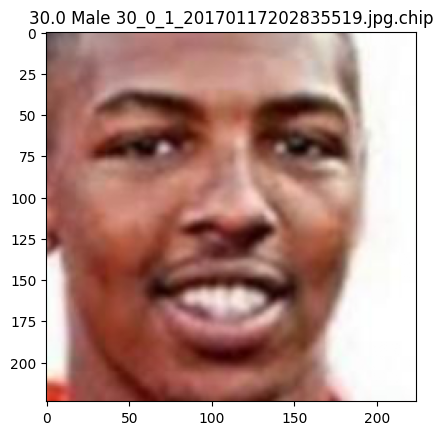

In [47]:
idx = np.random.randint(0, len(ImageFolderCustom(csv_file=train_df,transform=auto_transforms3)))
img, age, gen, imageid = ImageFolderCustom(csv_file=train_df,transform=auto_transforms3).__getitem__(idx)
plt.imshow(img.clone().detach().cpu().permute(1,2,0))
plt.title(f"{age} {gender[int(gen)]} {imageid}")

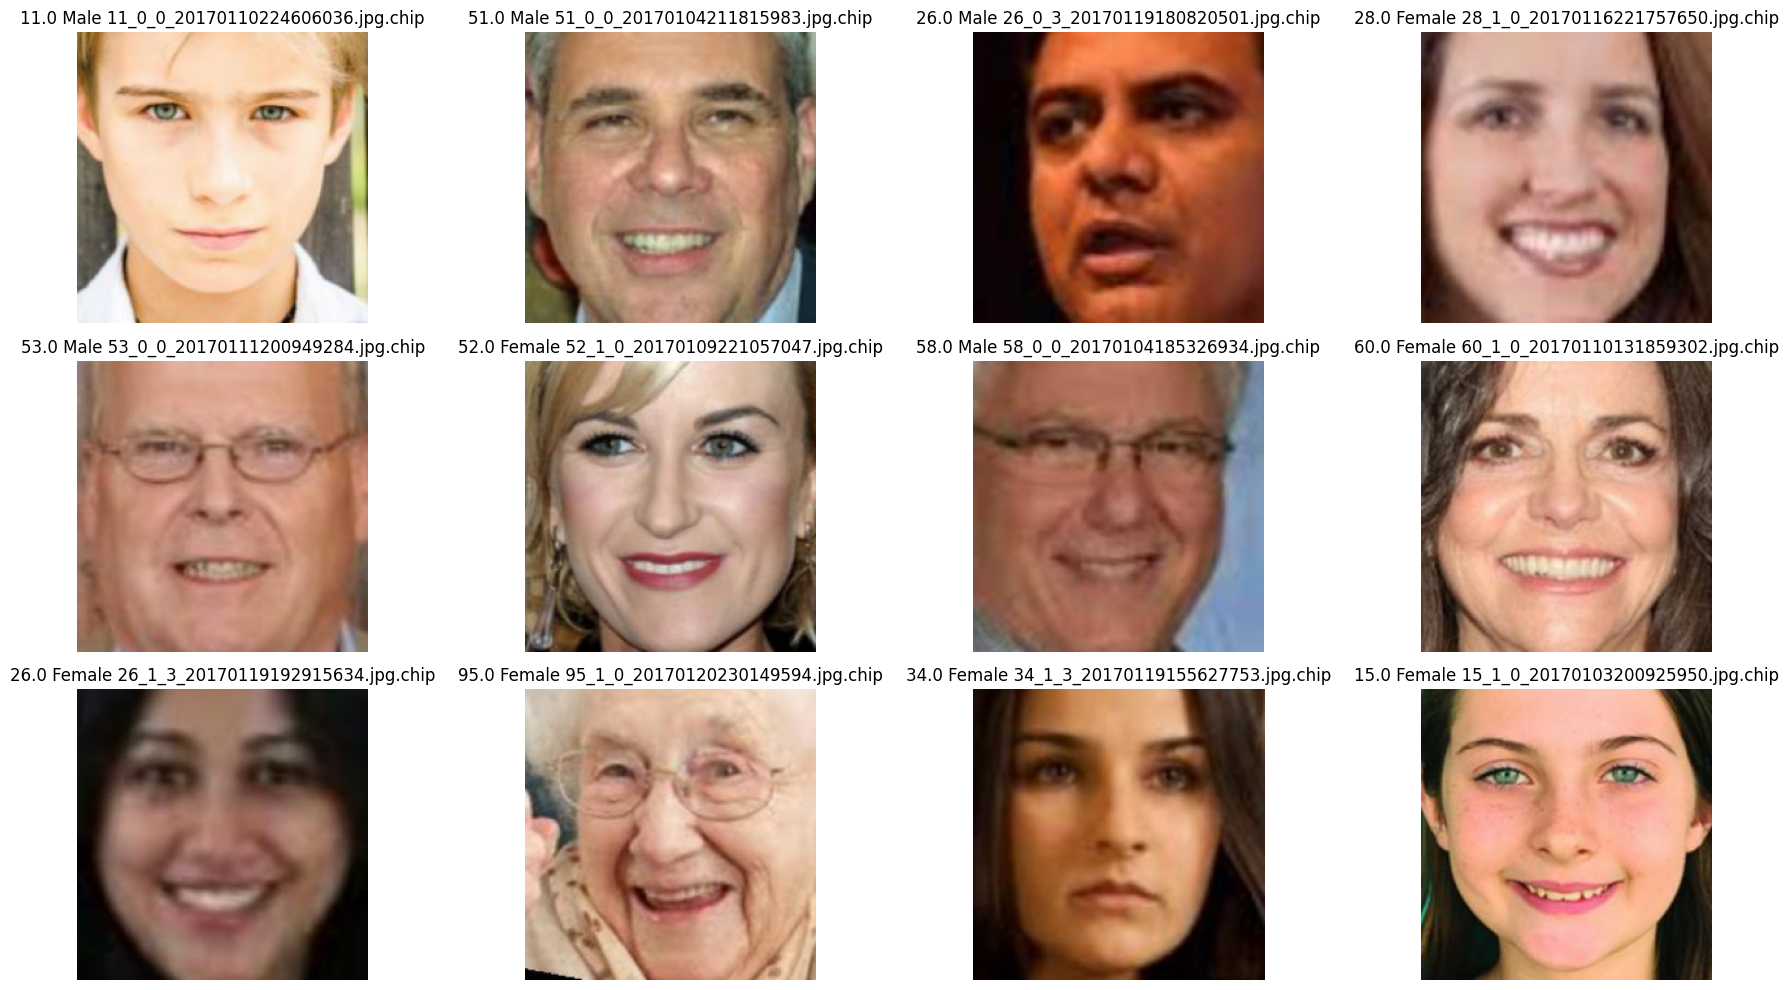

In [48]:
plt.figure(figsize=(19,10))
for i in range(0, 12):
    idx = np.random.randint(0, len(ImageFolderCustom(csv_file=train_df,transform=auto_transforms3)))
    img, age, gen, imageid = ImageFolderCustom(csv_file=train_df,transform=auto_transforms3).__getitem__(idx)
    plt.subplot(3, 4, i+1)
    plt.imshow(img.clone().detach().cpu().permute(1,2,0))
    plt.title(f"{age} {gender[int(gen)]} {imageid}")
    plt.axis(False)
plt.tight_layout()

#### 2.4 DataLoader

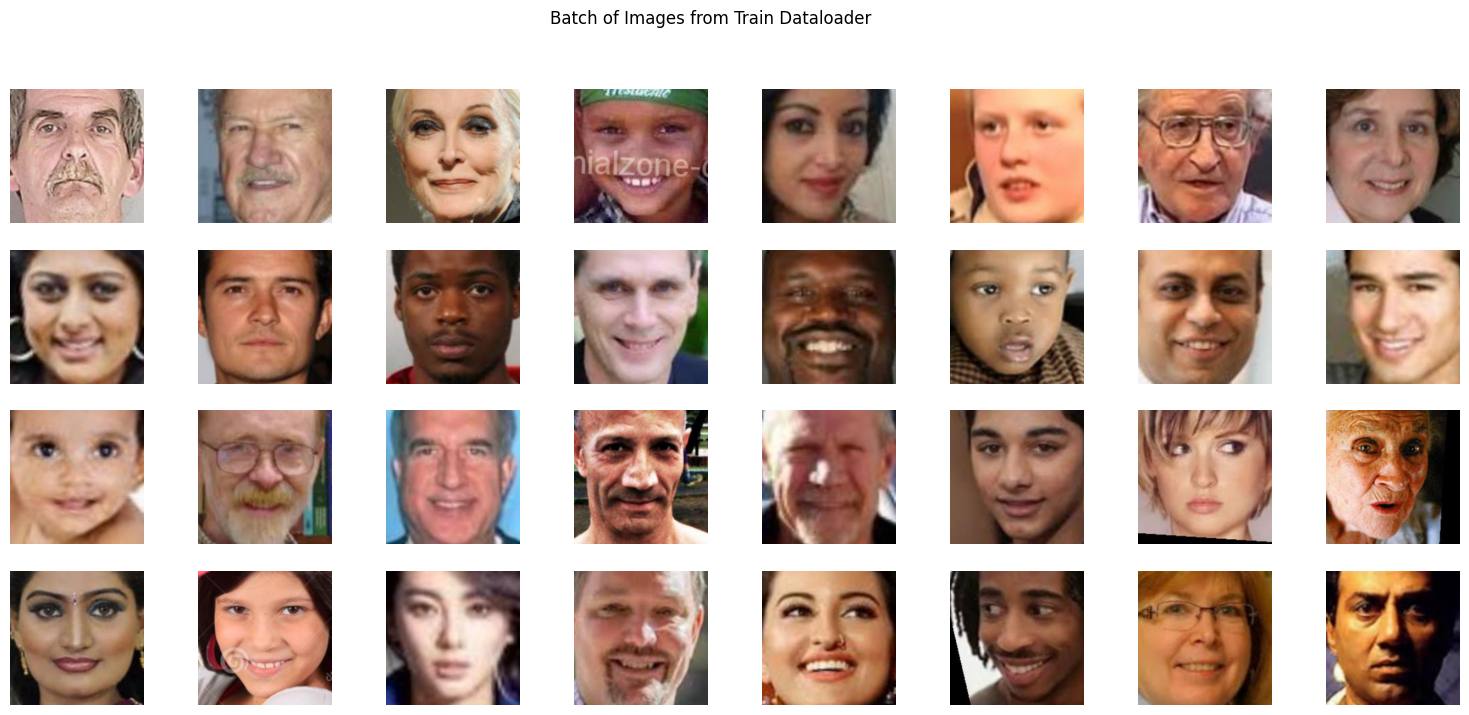

In [50]:
BATCH_SIZE = 64

train_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              pin_memory=False,
                              num_workers=int(os.cpu_count()/1),
                              persistent_workers=True,
                              drop_last=True,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=int(os.cpu_count()/1),
                             persistent_workers=True,
                             shuffle=False,
                             pin_memory=False,
                             drop_last=False)

images, ages, genders, imageid = next(iter(train_dataloader))

fig, axs = plt.subplots(4, 8, figsize=(19, 8))
for idx, ax in enumerate(axs.ravel()):
    ax.imshow(images[idx].permute(1, 2, 0))
#     ax.set_title(f"{ages[idx]} {gender[int(gen)]}")
    ax.axis('off')

plt.suptitle("Batch of Images from Train Dataloader")
plt.show()

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [ ]:
# loaded = torch.load(f"./vgg_face_dag.pth")
# loaded

In [ ]:
# loaded.keys()

In [ ]:
# for i, layer in enumerate(loaded.keys()):
#     print(i, layer, loaded[layer].shape)

In [ ]:
# cnn = models.vgg16(weights=)
# cnn

In [ ]:
# cnn = models.vgg16()
# cnn

In [51]:
effnet_weights = models.EfficientNet_B0_Weights.DEFAULT
vgg16_weights = models.VGG16_Weights.DEFAULT
effnet_pt = models.efficientnet_b0(weights=effnet_weights)
vgg16_pt = models.vgg16(weights=vgg16_weights)
effnet = models.efficientnet_b0()
vgg16 = models.vgg16()

cnn = vgg16_pt

# for param in cnn.features.parameters():
# for param in list(cnn.features.parameters())[:6]:
for i, param in enumerate(cnn.features.parameters()):
    if i <= 19:
        param.requires_grad = False


BATCH_SIZE = 32
summary(cnn,
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/23m1521/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 117MB/s] 


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU

In [52]:
summary(cnn.features,
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
├─Conv2d (0)                             [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
├─ReLU (1)                               [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
├─Conv2d (2)                             [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
├─ReLU (3)                               [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
├─MaxPool2d (4)                          [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
├─Conv2d (5)                             [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
├─ReLU (6)                               [32, 128, 112, 112]  [32, 128, 112, 112]  --                   --
├─Conv2d (7)    

In [53]:
summary(cnn.avgpool,
        input_size=(BATCH_SIZE, 512, 7, 7),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AdaptiveAvgPool2d (AdaptiveAvgPool2d)    [32, 512, 7, 7]      [32, 512, 7, 7]      --                   --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 3.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 3.21

In [54]:
cnn.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [55]:
summary(cnn.classifier,
        input_size=(BATCH_SIZE, 25088),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                  [32, 25088]          [32, 1000]           --                   True
├─Linear (0)                             [32, 25088]          [32, 4096]           102,764,544          True
├─ReLU (1)                               [32, 4096]           [32, 4096]           --                   --
├─Dropout (2)                            [32, 4096]           [32, 4096]           --                   --
├─Linear (3)                             [32, 4096]           [32, 4096]           16,781,312           True
├─ReLU (4)                               [32, 4096]           [32, 4096]           --                   --
├─Dropout (5)                            [32, 4096]           [32, 4096]           --                   --
├─Linear (6)                             [32, 4096]           [32, 1000]           4,097,000            True
Total params: 123,642,

In [56]:
features_ext = nn.Sequential(
    cnn.features,
    cnn.avgpool
)
summary(features_ext,
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Sequential (Sequential)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
├─Sequential (0)                         [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (5)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU

In [57]:
# cnn.classifier = nn.Sequential(
#     # nn.Dropout(p=0.2, inplace=False)
#     nn.Linear(in_features=1280, out_features=1280, bias=True)
# ).to(device)
# print(cnn.classifier)

# # cnn.classifier = nn.Sequential(*list(cnn.classifier.children())[:1]).to(device)
# summary(cnn,
#         input_size=(BATCH_SIZE, 3, 224, 224),
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
#         )

In [65]:
class MultiOutput_EffNetB0(nn.Module):
    def __init__(self):
        super(MultiOutput_EffNetB0, self).__init__()

        self.cnn = features_ext

        self.reg = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=4096, out_features=1, bias=False)
        )

        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=25088, out_features=4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(p=0.2, inplace=False),
            nn.Linear(in_features=4096, out_features=2, bias=False)
        )


    def forward(self, x):

        features = self.cnn(x)
        y1 = self.reg(features)
        y2 = self.clf(features)

        return y1, y2



model = MultiOutput_EffNetB0().to(device)

In [66]:
summary(model,
        input_size=(BATCH_SIZE, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MultiOutput_EffNetB0 (MultiOutput_EffNetB0)   [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (cnn)                            [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    └─Sequential (0)                         [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    │    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    │    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─MaxPool2d (4)                     [32, 64, 224, 224]   [32, 64, 

In [68]:
# model.load_state_dict(torch.load(f"./model_50.pth")).to(device)

In [69]:
X, y1, y2, id = next(iter(train_dataloader))

model.eval()
with torch.inference_mode():
    pred1, pred2 = model(X.to(device))
    pred1 = pred1.squeeze()
    pred2 = pred2.squeeze()
pred1, pred2

(tensor([-0.0453, -0.0123, -0.0493, -0.0273, -0.0615,  0.0427,  0.0053,  0.0214,
         -0.0026, -0.0635,  0.0066, -0.0179, -0.0087,  0.0170, -0.0543, -0.0272,
         -0.0613, -0.0513,  0.0330, -0.0220,  0.0006, -0.0248, -0.0202, -0.0383,
         -0.0400, -0.0074,  0.0254, -0.0188,  0.0473, -0.0406, -0.0045,  0.0172,
          0.0106,  0.0320, -0.0562, -0.0536, -0.0171, -0.0490, -0.0470, -0.0591,
         -0.0339,  0.0409, -0.0462,  0.0064, -0.0308, -0.0265,  0.0603, -0.0056,
         -0.0351, -0.0028, -0.0259,  0.0127, -0.0372, -0.0316, -0.0529, -0.0391,
          0.0067, -0.0567, -0.0133, -0.0405,  0.0372, -0.0245, -0.0479, -0.0130],
        device='cuda:0'),
 tensor([[-6.3433e-02,  3.5923e-02],
         [-7.2795e-02, -3.2050e-02],
         [-1.0037e-01,  1.3390e-02],
         [-7.5455e-02, -2.6833e-02],
         [-7.9486e-02, -6.7279e-06],
         [-7.8907e-02,  7.4791e-03],
         [-7.4277e-02,  4.4116e-02],
         [-1.0821e-01, -1.0117e-02],
         [-1.0293e-01,  1.519

In [70]:
pred2.shape

torch.Size([64, 2])

In [71]:
pred2[0].softmax(dim=0).argmax()

tensor(1, device='cuda:0')

In [72]:
pred2.softmax(dim=1).argmax(dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

In [73]:
y2

tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1])

- `.detach()` remove tensor from gradient computation
- `.cpu()` move tensor from GPU to CPU

For comverting a tensor:
1. Use `.detach()` it, then move it to the `.cpu()` then convert it to `.numpy()`

In [ ]:
# pred2[:2], pred2[:2].detach()

In [ ]:
# pred2[:2], pred2[:2].cpu()

In [ ]:
# pred2[:2], pred2[:2].detach().cpu().numpy()

In [ ]:
# loss_fn1 = nn.L1Loss() # Age loss
# loss_fn2 = nn.BCEWithLogitsLoss() # Gender loss

In [ ]:
# loss1 = loss_fn1(pred1.cpu(), y1)
# loss1

In [ ]:
# loss2 = loss_fn2(pred2.cpu(), y2)
# loss2

In [ ]:
# print(pred1, y1)

In [ ]:
# print(torch.round(pred2), y2)

## 4. Train model and track results

In [ ]:
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [ ]:
# model = torch.nn.DataParallel(model, device_ids=[0])
# model.to(device)

In [74]:
train_dl_len = len(train_dataloader)
test_dl_len = len(test_dataloader)
train_dl_len, test_dl_len

(277, 93)

In [75]:
'''optimizer'''
def __get_optimizer(optimizer: str):
    if optimizer == 'adam':
        return torch.optim.Adam(params=model.parameters(), 
                                lr=0.001,
                                weight_decay=1e-6,
                                amsgrad=False)

    elif optimizer == 'adamw':
        return torch.optim.AdamW(params=model.parameters(), 
                                 lr=0.001,
                                 weight_decay=1e-6,)

    elif optimizer == 'sgd':
        return torch.optim.SGD(params=model.parameters(), 
                               lr=0.001)


'''lr scheduler'''
def __get_lr_scheduler(lr_sch: str, optimizer):
    if lr_sch == 'ReduceLROnPlateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                          mode='min', 
                                                          factor=0.2, 
                                                          patience=4, 
                                                          eps=1e-6)
        
    elif lr_sch == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                          T_max=15,
                                                          eta_min=1e-6,
                                                          last_epoch=-1)
        
    elif lr_sch == 'CosineAnnealingWarmRestarts':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                    T_0=10,
                                                                    eta_min=1e-6,
                                                                    last_epoch=-1)
        
        
'''loss fun'''
loss_fn1 = nn.L1Loss()
loss_fn2 = torch.nn.CrossEntropyLoss()

optimizer = __get_optimizer("sgd")
lr_scheduler = __get_lr_scheduler("CosineAnnealingWarmRestarts", optimizer)


'''train fun'''
def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn1: torch.nn.Module,
                loss_fn2: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                lr_scheduler:torch.optim.lr_scheduler,
                device: torch.device,
                epochs: int = 3,
                seed=None,
                plot=True):


    start_time = timer()
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

    results = {"train_loss1": [],
               "train_loss2": [],
               "test_loss1": [],
               "test_loss2": [],
               "train_loss": [],
               "test_loss": [],
               "train_acc2": [],
               "test_acc2": [],
               "train_f1": [],
               "test_f1": []
               }
    test_loss1, test_loss2 = np.inf, np.inf
    
    for epoch in tqdm(range(epochs), desc="Train Epoch"):

        ### Training loop
        cum_train_loss, cum_train_loss1, cum_train_loss2, cum_train_acc2, cum_train_f1 = 0, 0, 0, 0, 0
        model.train()

        for batch, (X, y1, y2, _) in enumerate(tqdm(train_dataloader, desc="Train Batch", total=train_dl_len)):

            X, y1, y2 = X.to(device), y1.to(device), y2.to(device)

            y1_pred, y2_logit = model(X)

            train_loss1 = loss_fn1(y1_pred.squeeze(), y1)
            train_loss2 = loss_fn2(y2_logit.squeeze(), y2)
            
            total_loss = train_loss1 + train_loss2
            cum_train_loss += total_loss.item()
            optimizer.zero_grad()
            
            percentage_diff_loss1 = abs(test_loss1 - train_loss1) / train_loss1 * 100
            percentage_diff_loss2 = abs(test_loss2 - train_loss2) / train_loss2 * 100
            
            if   (percentage_diff_loss1 > 5) and (percentage_diff_loss2 > 5):
                total_loss.backward()
            elif (percentage_diff_loss1 > 5) and (percentage_diff_loss2 < 5):
                train_loss1.backward()
            elif (percentage_diff_loss2 > 5) and (percentage_diff_loss1 < 5):
                train_loss2.backward()
            
            cum_train_loss1 += train_loss1.item()
            cum_train_loss2 += train_loss2.item()
            
            optimizer.step()
            lr_scheduler.step()

            y2_pred = y2_logit.softmax(dim=1).argmax(dim=1)
            cum_train_acc2 += 100*accuracy_score(y2.detach().cpu().numpy(), y2_pred.detach().cpu().numpy())
            cum_train_f1 += 100*f1_score(y2.detach().cpu().numpy(), y2_pred.detach().cpu().numpy(), average='micro')
        
        
        cum_train_loss /= len(train_dataloader)
        cum_train_loss1 /= len(train_dataloader)
        cum_train_loss2 /= len(train_dataloader)
        cum_train_acc2 /= len(train_dataloader)
        cum_train_f1 /= len(train_dataloader)


        ### Testing loop
        cum_test_loss, cum_test_loss1, cum_test_loss2, cum_test_acc2, cum_test_f1 = 0, 0, 0, 0, 0
        model.eval()

        with torch.inference_mode():
            for X_test, y1_test, y2_test,_ in tqdm(test_dataloader, desc="Test Batch", total=test_dl_len):
                X_test, y1_test, y2_test = X_test.to(device), y1_test.to(device), y2_test.to(device)

                y1_test_pred, y2_test_logit = model(X_test)

                test_loss1 = loss_fn1(y1_test_pred.squeeze(), y1_test).item()
                test_loss2 = loss_fn2(y2_test_logit.squeeze(),  y2_test).item()
                
                
                cum_test_loss += test_loss1 + test_loss2
                cum_test_loss1 += test_loss1
                cum_test_loss2 += test_loss2

                y2_test_pred = y2_test_logit.softmax(dim=1).argmax(dim=1)
                cum_test_acc2 += 100*accuracy_score(y2_test.detach().cpu().numpy(), y2_test_pred.detach().cpu().numpy())
                cum_test_f1 += 100*f1_score(y2_test.detach().cpu().numpy(), y2_test_pred.detach().cpu().numpy(), average='micro')

            cum_test_loss /= len(test_dataloader)
            cum_test_loss1 /= len(test_dataloader)
            cum_test_loss2 /= len(test_dataloader)
            cum_test_acc2 /= len(test_dataloader)
            cum_test_f1 /= len(test_dataloader)
            


        print(f"Epoch: {epoch} |"
              f"Train loss1: {cum_train_loss1:.4f} |"
              f"Test loss1: {cum_test_loss1:.4f} |"
              f"Train loss2: {cum_train_loss2:.4f} |"
              f"Test loss2: {cum_test_loss2:.4f} |"
              f"Train loss: {cum_train_loss:.4f} |"
              f"Test loss: {cum_test_loss:.4f} |"
              f"Train acc2: {cum_train_acc2:.4f}% |"
              f"Test acc2: {cum_test_acc2:.4f}% |"
              f"Train f1: {cum_train_f1:.4f}% |"
              f"Test f1: {cum_test_f1:.4f}%")


        results["train_loss1"].append(cum_train_loss1)
        results["train_loss2"].append(cum_train_loss2)
        results["test_loss1"].append(cum_test_loss1)
        results["test_loss2"].append(cum_test_loss2)
        results["train_loss"].append(cum_train_loss)
        results["test_loss"].append(cum_test_loss)
        results["train_acc2"].append(cum_train_acc2)
        results["test_acc2"].append(cum_test_acc2)
        results["train_f1"].append(cum_train_f1)
        results["test_f1"].append(cum_test_f1)


    end_time = timer()
    print(f"Train time on {device} is ", format_time(start_time, end_time))


    if plot:
        
        plt.figure(figsize=(10, 20))
        plt.subplot(5, 1, 1)
        plt.plot(np.arange(1,epochs+1), results["train_loss1"], label='Train Loss 1', color='blue')
        plt.plot(np.arange(1,epochs+1), results["test_loss1"], label='Test Loss 1', color='orange')
        plt.title('Loss 1')
        plt.legend()

        plt.subplot(5, 1, 2)
        plt.plot(np.arange(1,epochs+1), results["train_loss2"], label='Train Loss 2', color='blue')
        plt.plot(np.arange(1,epochs+1), results["test_loss2"], label='Test Loss 2', color='orange')
        plt.title('Loss 2')
        plt.legend()

        plt.subplot(5, 1, 3)
        plt.plot(np.arange(1,epochs+1), results["train_loss"], label='Train Loss', color='blue')
        plt.plot(np.arange(1,epochs+1), results["test_loss"], label='Test Loss', color='orange')
        plt.title('Loss')
        plt.legend()

        plt.subplot(5, 1, 4)
        plt.plot(np.arange(1,epochs+1), results["train_acc2"], label='Train Accuracy 2', color='blue')
        plt.plot(np.arange(1,epochs+1), results["test_acc2"], label='Test Accuracy 2', color='orange')
        plt.title('Accuracy 2')
        plt.legend()

        plt.subplot(5, 1, 5)
        plt.plot(np.arange(1,epochs+1), results["train_f1"], label='Train F1 Score', color='blue')
        plt.plot(np.arange(1,epochs+1), results["test_f1"], label='Test F1 Score', color='orange')
        plt.title('F1 Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return results

In [76]:
!rm -rf saved_model3
os.makedirs("saved_model3", exist_ok=True)
save_dir = Path("./saved_model3")
torch.save(model.state_dict(), f"{save_dir}/model3_0.pth")

Saved model3 found in "saved_model3/model3_3.pth" at 3 epochs, loading...
Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MultiOutput_EffNetB0 (MultiOutput_EffNetB0)   [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Sequential (cnn)                            [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    └─Sequential (0)                         [32, 3, 224, 224]    [32, 512, 7, 7]      --                   Partial
│    │    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    │    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    │    └─Conv2d (2)                        [32, 64, 224, 224]   [32, 64, 224, 224]   (36,928)             False
│    │    └─ReLU (3)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│ 

Train Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 0 |Train loss1: 33.4840 |Test loss1: 33.2727 |Train loss2: 0.6556 |Test loss2: 0.6334 |Train loss: 34.1396 |Test loss: 33.9061 |Train acc2: 59.9278% |Test acc2: 61.1839% |Train f1: 59.9278% |Test f1: 61.1839%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 1 |Train loss1: 33.4739 |Test loss1: 33.2484 |Train loss2: 0.6326 |Test loss2: 0.6117 |Train loss: 34.1066 |Test loss: 33.8601 |Train acc2: 62.5451% |Test acc2: 65.3049% |Train f1: 62.5451% |Test f1: 65.3049%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 2 |Train loss1: 33.4632 |Test loss1: 33.2822 |Train loss2: 0.6147 |Test loss2: 0.5904 |Train loss: 34.0780 |Test loss: 33.8726 |Train acc2: 64.7507% |Test acc2: 68.5139% |Train f1: 64.7507% |Test f1: 68.5139%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 3 |Train loss1: 33.4488 |Test loss1: 33.2773 |Train loss2: 0.5943 |Test loss2: 0.5776 |Train loss: 34.0431 |Test loss: 33.8549 |Train acc2: 66.7419% |Test acc2: 69.7895% |Train f1: 66.7419% |Test f1: 69.7895%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 4 |Train loss1: 33.4612 |Test loss1: 33.2687 |Train loss2: 0.5774 |Test loss2: 0.5618 |Train loss: 34.0386 |Test loss: 33.8305 |Train acc2: 68.8403% |Test acc2: 72.2364% |Train f1: 68.8403% |Test f1: 72.2364%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 5 |Train loss1: 33.4723 |Test loss1: 33.2736 |Train loss2: 0.5627 |Test loss2: 0.5509 |Train loss: 34.0350 |Test loss: 33.8245 |Train acc2: 70.0023% |Test acc2: 72.9925% |Train f1: 70.0023% |Test f1: 72.9925%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 6 |Train loss1: 33.4642 |Test loss1: 33.2815 |Train loss2: 0.5500 |Test loss2: 0.5356 |Train loss: 34.0142 |Test loss: 33.8171 |Train acc2: 71.4914% |Test acc2: 74.3870% |Train f1: 71.4914% |Test f1: 74.3870%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 7 |Train loss1: 33.4653 |Test loss1: 33.2676 |Train loss2: 0.5378 |Test loss2: 0.5292 |Train loss: 34.0031 |Test loss: 33.7968 |Train acc2: 73.1216% |Test acc2: 74.7842% |Train f1: 73.1216% |Test f1: 74.7842%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 8 |Train loss1: 33.4808 |Test loss1: 33.2748 |Train loss2: 0.5288 |Test loss2: 0.5166 |Train loss: 34.0097 |Test loss: 33.7914 |Train acc2: 73.8493% |Test acc2: 76.2627% |Train f1: 73.8493% |Test f1: 76.2627%


Train Batch:   0%|          | 0/277 [00:00<?, ?it/s]

Test Batch:   0%|          | 0/93 [00:00<?, ?it/s]

Epoch: 9 |Train loss1: 33.4669 |Test loss1: 33.2790 |Train loss2: 0.5144 |Test loss2: 0.5077 |Train loss: 33.9813 |Test loss: 33.7867 |Train acc2: 75.1297% |Test acc2: 76.9623% |Train f1: 75.1297% |Test f1: 76.9623%
Train time on cuda is  7 minutes 12.39 seconds


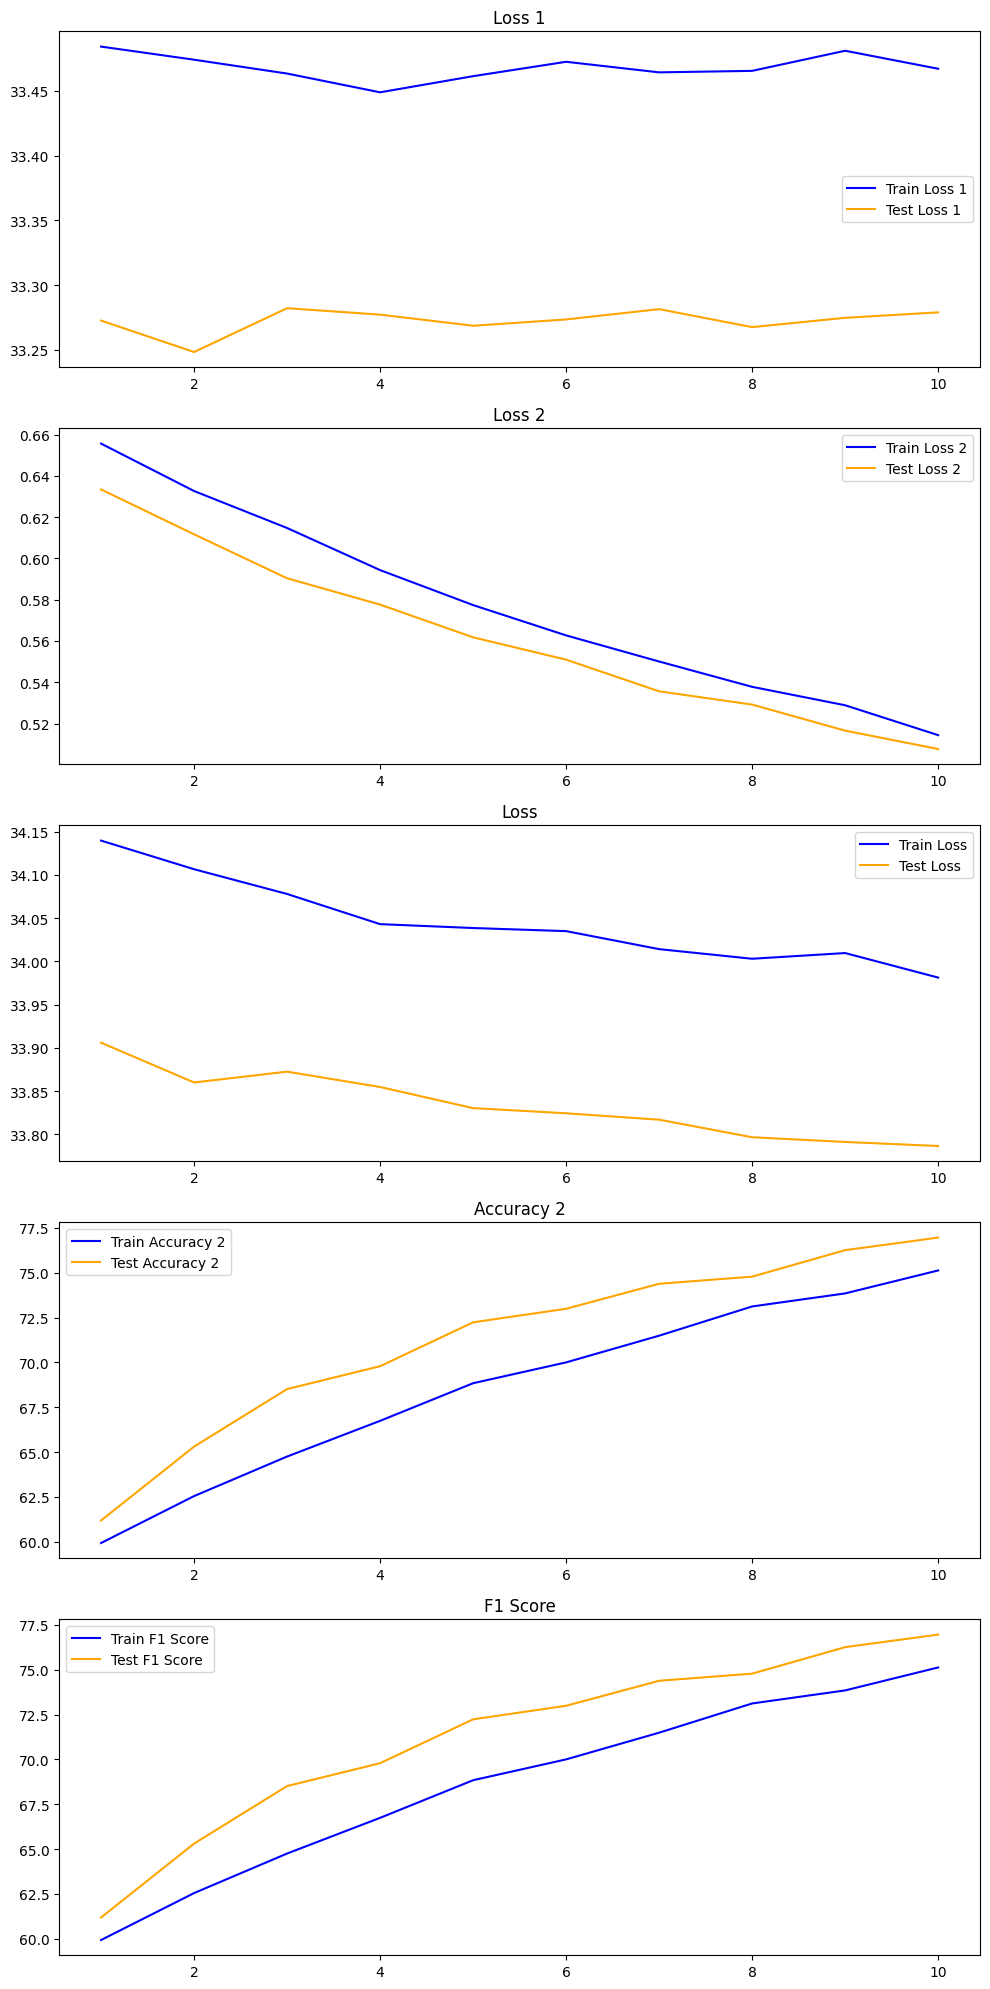

removed 'saved_model3/model3_3.pth'
saved model3 saved_model3/model3_13.pth


In [81]:
epochs = 10
save_dir = Path("./saved_model3")

# import gdown
# url = "https://drive.google.com/drive/folders/1kakqPz8r4uIrMSJxGYv5sg-a9dgrq3F7?usp=sharing"
# gdown.download_folder(url=url)


if len(glob(f"./{save_dir}/*.pth")) != 0:
    saved_model_path = Path(glob(f"./{save_dir}/*.pth")[0])
    saved_model_name = Path(glob(f"./{save_dir}/*.pth")[0]).stem
    saved_model_ep = Path(glob(f"./{save_dir}/*.pth")[0]).stem.split("_")[-1]
    print(f"Saved model3 found in \"{saved_model_path}\" at {saved_model_ep} epochs, loading...")
    
    model = MultiOutput_EffNetB0()
    model.load_state_dict(torch.load(saved_model_path, map_location=device))
    for i, param in enumerate(model.cnn.parameters()):
        if i <= 19:
            param.requires_grad = False

    summ = summary(model,
            input_size=(BATCH_SIZE, 3, 224, 224),
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"]
            )
    print(summ)

    model_results = train_model(model=model.to(device),
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                loss_fn1=loss_fn1,
                                loss_fn2=loss_fn2,
                                optimizer=optimizer,
                                lr_scheduler=lr_scheduler,
                                device=device,
                                epochs=epochs,
                                seed=42,
                                plot=True)
    
    
    torch.save(model.state_dict(), f"{save_dir}/model3_{int(saved_model_ep)+epochs}.pth")
    subprocess.run(f"rm -vrf {str(saved_model_path)}", shell=True)
    print(f"saved model3 {save_dir}/model3_{int(saved_model_ep)+epochs}.pth")

In [78]:
model_results

{'train_loss1': [33.48725174308254, 33.46319969810734, 33.4686696710139],
 'train_loss2': [0.7537683594958446, 0.7161410102345023, 0.6907676757457885],
 'test_loss1': [33.27458633915071, 33.27582457757765, 33.2647341246246],
 'test_loss2': [0.7162584149709312, 0.6860110919962648, 0.6672355372418639],
 'train_loss': [34.24102009935069, 34.17934067929264, 34.15943743433763],
 'test_loss': [33.99084475412164, 33.961835669573915, 33.93196966186647],
 'train_acc2': [49.847698555956676, 53.559341155234655, 55.97924187725632],
 'test_acc2': [51.24629514750482, 54.44323821339951, 56.50373931623932],
 'train_f1': [49.847698555956676, 53.559341155234655, 55.97924187725632],
 'test_f1': [51.24629514750482, 54.44323821339951, 56.50373931623932]}

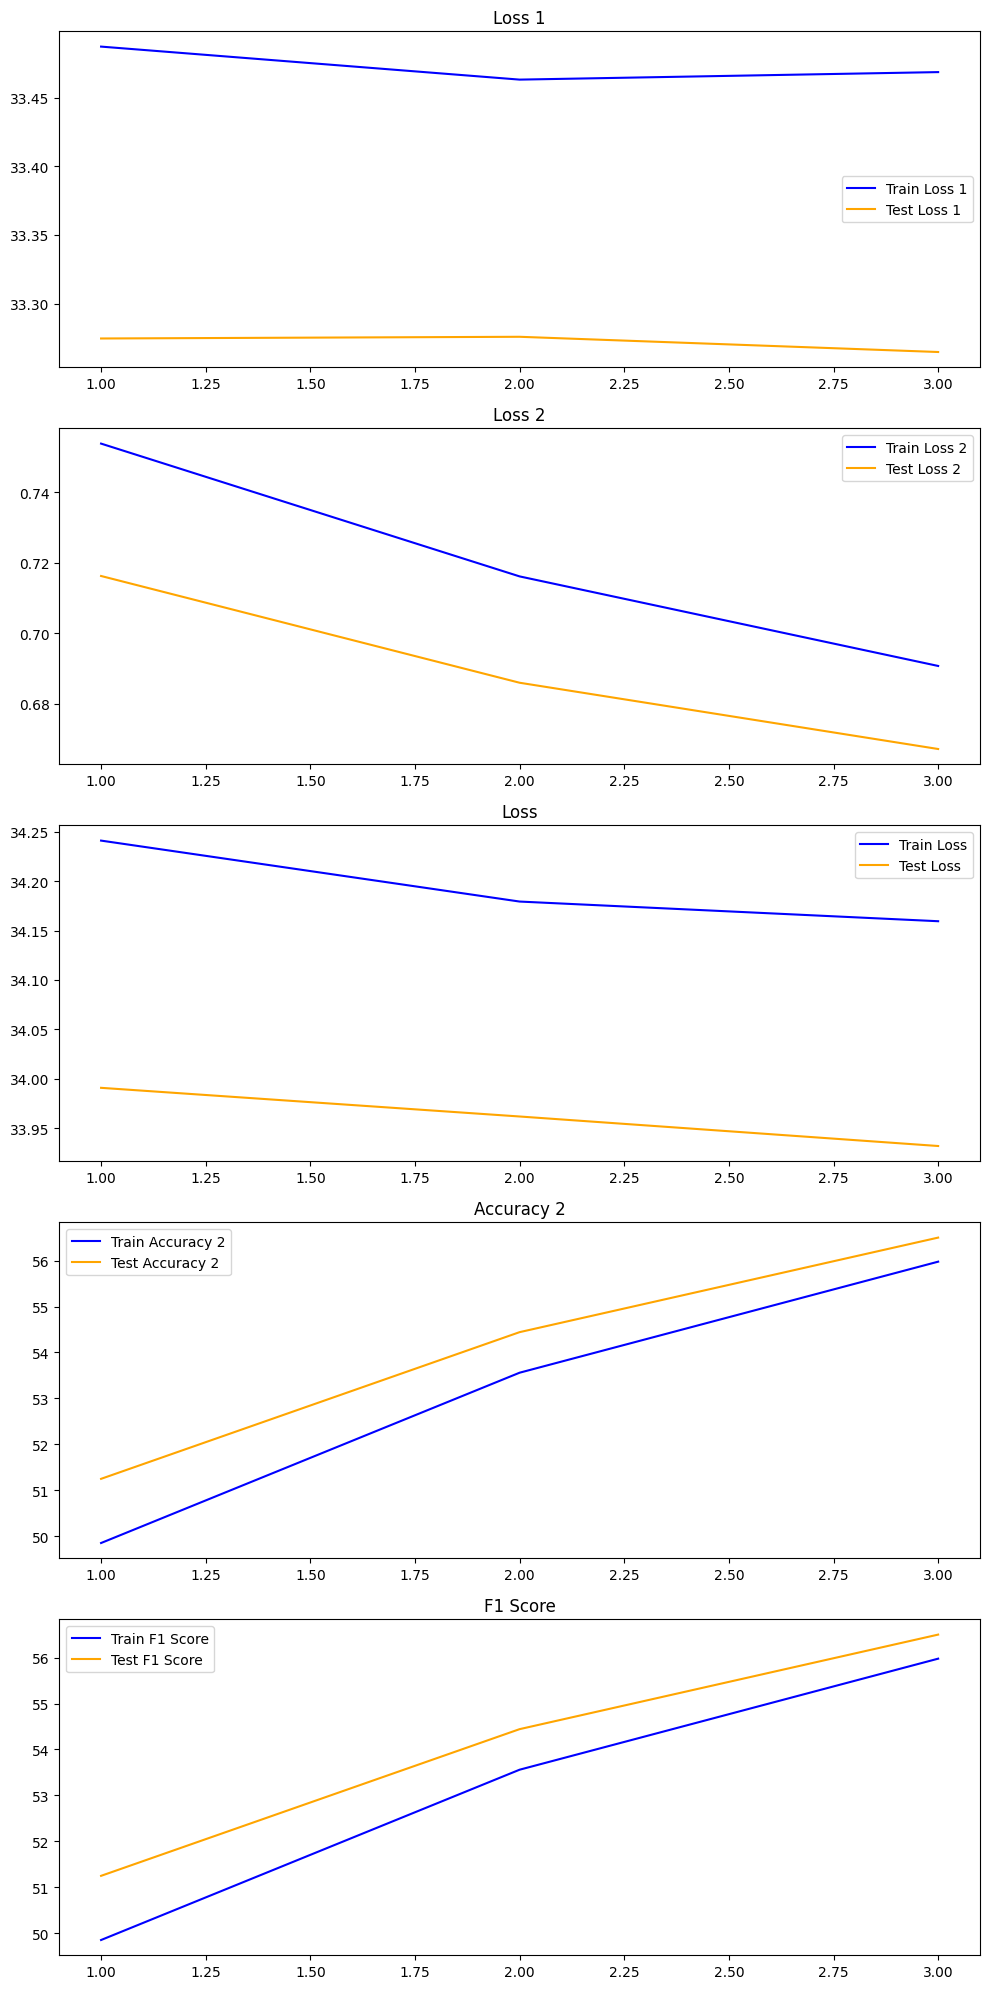

In [79]:
plt.figure(figsize=(10, 20))
plt.subplot(5, 1, 1)
plt.plot(np.arange(1,epochs+1), model_results["train_loss1"], label='Train Loss 1', color='blue')
plt.plot(np.arange(1,epochs+1), model_results["test_loss1"], label='Test Loss 1', color='orange')
plt.title('Loss 1')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(np.arange(1,epochs+1), model_results["train_loss2"], label='Train Loss 2', color='blue')
plt.plot(np.arange(1,epochs+1), model_results["test_loss2"], label='Test Loss 2', color='orange')
plt.title('Loss 2')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(np.arange(1,epochs+1), model_results["train_loss"], label='Train Loss', color='blue')
plt.plot(np.arange(1,epochs+1), model_results["test_loss"], label='Test Loss', color='orange')
plt.title('Loss')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(np.arange(1,epochs+1), model_results["train_acc2"], label='Train Accuracy 2', color='blue')
plt.plot(np.arange(1,epochs+1), model_results["test_acc2"], label='Test Accuracy 2', color='orange')
plt.title('Accuracy 2')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(np.arange(1,epochs+1), model_results["train_f1"], label='Train F1 Score', color='blue')
plt.plot(np.arange(1,epochs+1), model_results["test_f1"], label='Test F1 Score', color='orange')
plt.title('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

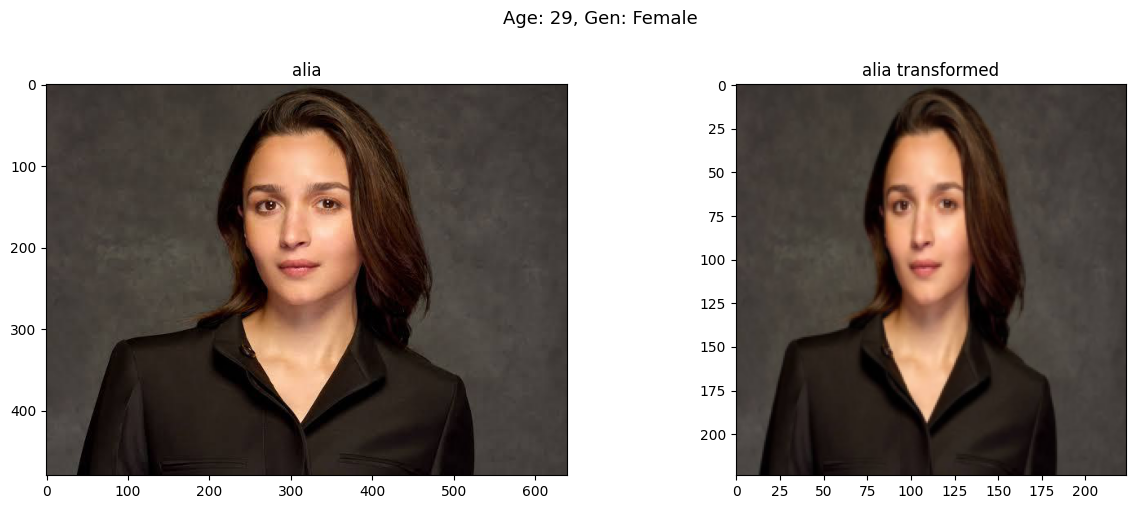

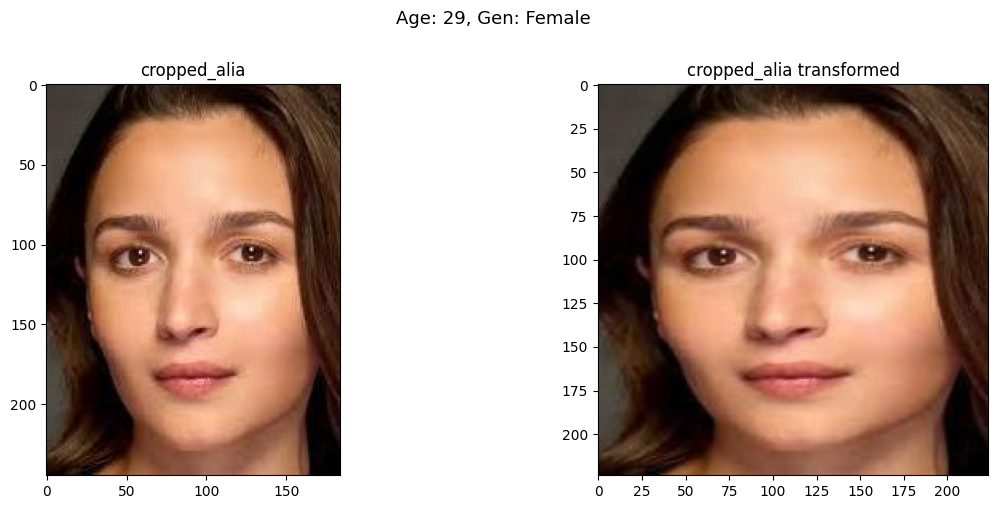

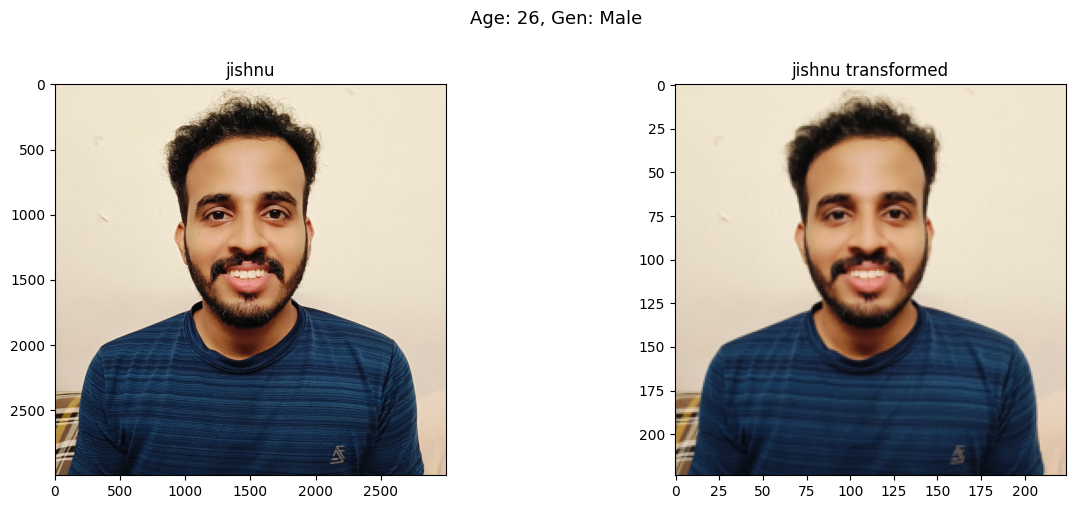

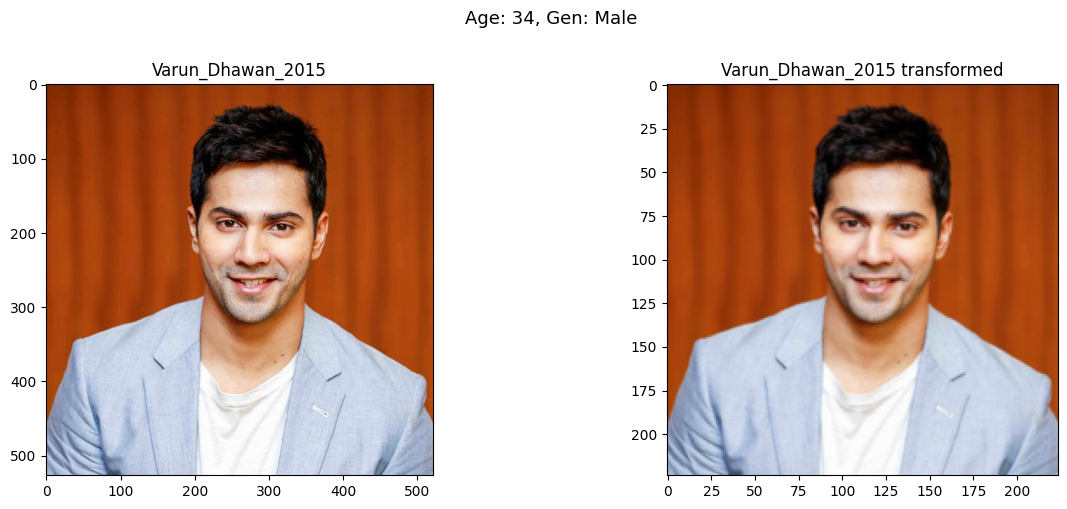

In [91]:
gender = {0 : 'Male', 1 : "Female"}

def Make_pred(img_path: str):
    plt.figure(figsize=(13,5))
    img = Image.open(img_path)
    img_name = Path(img_path).stem
    ch = len(img.getbands())
    if  ch != 3:
        img = img.convert('RGB')
    imgt = auto_transforms3(img)

    plt.subplot(1,2,1); plt.imshow(img)
    plt.title(img_name)
    plt.subplot(1,2,2);plt.imshow(imgt.permute(1,2,0))
    plt.title(f"{img_name} transformed")

    save_dir = Path("./saved_model3")
    saved_model_path = Path(glob(f"./{save_dir}/*.pth")[0])
    model = MultiOutput_EffNetB0().to(device)
    model.load_state_dict(torch.load(saved_model_path, map_location=device))
    model.eval()
    with torch.inference_mode():
        pred1, pred2 = model(imgt.unsqueeze(dim=0).to(device))
        pred1 = pred1
        pred2 = pred2    
    
    age = torch.round(pred1.detach().cpu()).item()
    gen = gender[pred2.softmax(dim=1).argmax(dim=1).detach().cpu().item()]

    plt.suptitle(f"Age: {'age'}, Gen: {gen}", fontsize=13, verticalalignment="baseline")
    plt.tight_layout()
    plt.show()


def Get_images(dir_path):
    image_files = []
    for i in ["jpg", "jpeg", "png"]:
        image_files.extend(glob(f"{dir_path}/*.{i}"))
    return image_files

for img in Get_images('test_images'):
    Make_pred(img)